In [ ]:
%cd /Midgard/home/amirme/an_explanation_model

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial

from source.project_manager import (
    load_experiment_consistency,
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from commands.experiment_6_0 import (
    save_metadata_dir,
    dataset_dir,
    input_shape,
    save_output_dir,
)
os.makedirs(save_output_dir, exist_ok=True)
from source.data_manager import (
    preprocess_masks,
    plot_masks,
    minmax_normalize,
    sum_channels,
    symmetric_minmax_normalize,
    single_query_imagenet,
    save_axis,
)
from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "viridis", "vmin": 0, "vmax": 1}

query_imagenet = partial(
    single_query_imagenet, dataset_dir=dataset_dir, input_shape=input_shape
)

In [2]:
project_metadata = load_experiment_metadata(save_metadata_dir)
print(project_metadata.columns)
project_metadata = project_metadata.set_index(
    [
        "stream_name",
        "stream_statistic",
        "image_index",
        "baseline_mask_type",
        "alpha_mask_value",
    ]
).sort_index()
print(project_metadata.shape)

Index(['time_to_compute', 'batch_index', 'monitored_statistic_change',
       'path_prefix', 'data_path', 'stream_name', 'stream_statistic',
       'alpha_mask_type', 'alpha_mask_value', 'baseline_mask_type',
       'projection_type', 'projection_distribution', 'projection_top_k',
       'projection_index', 'label', 'architecture', 'method', 'output_layer',
       'dataset', 'image_index', 'input_shape', 'num_classes', 'seed',
       'batch_size', 'max_batches', 'min_change', 'metadata_file_path'],
      dtype='object')
(1050, 22)


In [3]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))
image_indices = project_metadata.index.get_level_values("image_index").unique()

stream_name            stream_statistic  image_index  baseline_mask_type  alpha_mask_value
log_probs              meanx             1            gaussian            0.0                 1
results_at_projection  meanx             97           gaussian            0.3                 1
                                                                          0.5                 1
                                                                          0.6                 1
                                         99           gaussian            0.0                 1
                                                                                             ..
                                         1            gaussian            0.5                 1
                                                                          0.6                 1
                                         3            gaussian            0.0                 1
                                             

In [4]:
for name in project_metadata.index.names:
    print(name,"=",project_metadata.index.get_level_values(name).value_counts().to_dict())

stream_name = {'log_probs': 350, 'results_at_projection': 350, 'vanilla_grad_mask': 350}
stream_statistic = {'meanx': 700, 'meanx2': 350}
image_index = {1: 21, 75: 21, 55: 21, 57: 21, 59: 21, 61: 21, 63: 21, 65: 21, 67: 21, 69: 21, 71: 21, 73: 21, 77: 21, 3: 21, 79: 21, 81: 21, 83: 21, 85: 21, 87: 21, 89: 21, 91: 21, 93: 21, 95: 21, 97: 21, 53: 21, 51: 21, 49: 21, 47: 21, 5: 21, 7: 21, 9: 21, 11: 21, 13: 21, 15: 21, 17: 21, 19: 21, 21: 21, 23: 21, 25: 21, 27: 21, 29: 21, 31: 21, 33: 21, 35: 21, 37: 21, 39: 21, 41: 21, 43: 21, 45: 21, 99: 21}
baseline_mask_type = {'gaussian': 1050}
alpha_mask_value = {0.0: 150, 0.1: 150, 0.2: 150, 0.3: 150, 0.4: 150, 0.5: 150, 0.6: 150}


In [5]:
consistency_data = load_experiment_consistency(save_metadata_dir)
print(consistency_data.columns)

Index(['consistency', 'image_index', 'projection_index'], dtype='object')


In [6]:
top5 = consistency_data.sort_values("consistency", ascending=False).head(5)
top5

,consistency,image_index,projection_index
34,0.712709,69,21
48,0.705801,97,109
8,0.642033,17,847
3,0.631517,7,547
45,0.631044,91,844


In [7]:
bottom5 = consistency_data.sort_values("consistency", ascending=True).head(5)
bottom5

,consistency,image_index,projection_index
27,0.249535,55,640
21,0.251067,43,104
4,0.277577,9,833
33,0.289645,67,716
22,0.304824,45,206


<Axes: title={'center': 'consistency'}, ylabel='Density'>

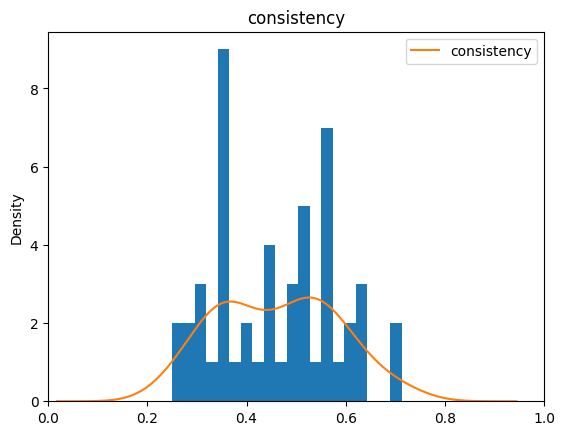

In [8]:
consistency_data.hist(column="consistency", bins=20,)
consistency_data.plot.kde(y="consistency",ax=plt.gca(),xlim=(0,1))

In [11]:
image_index = 7
original_image, label, image_path = query_imagenet(image_index=image_index)
temp = project_metadata.loc[("vanilla_grad_mask", "meanx2", image_index, "gaussian")]
temp_masks = temp["data_path"].apply(np.load)
titles = temp.index.to_series().apply(lambda x: f"alpha {x:.2f}")
temp_masks = preprocess_masks(temp_masks, preprocesses=[sum_channels, minmax_normalize])
fig, axes = plot_masks(temp_masks, titles=titles, imshow_args=imshow_args, ncols=4)
axes[1, 3].imshow(original_image[0].squeeze(), **imshow_args)
axes[1, 3].set_title(f"original ({IMAGENET_LABELS[label]})")
plt.draw()
save_axis(titles, fig, axes, save_output_dir)

2023-10-27 15:13:24.795316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [50000]
	 [[{{node Placeholder/_1}}]]
2023-10-27 15:13:24.795809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [50000]
	 [[{{node Placeholder/_1}}]]


Text(0.5, 1.0, 'original (wombat)')

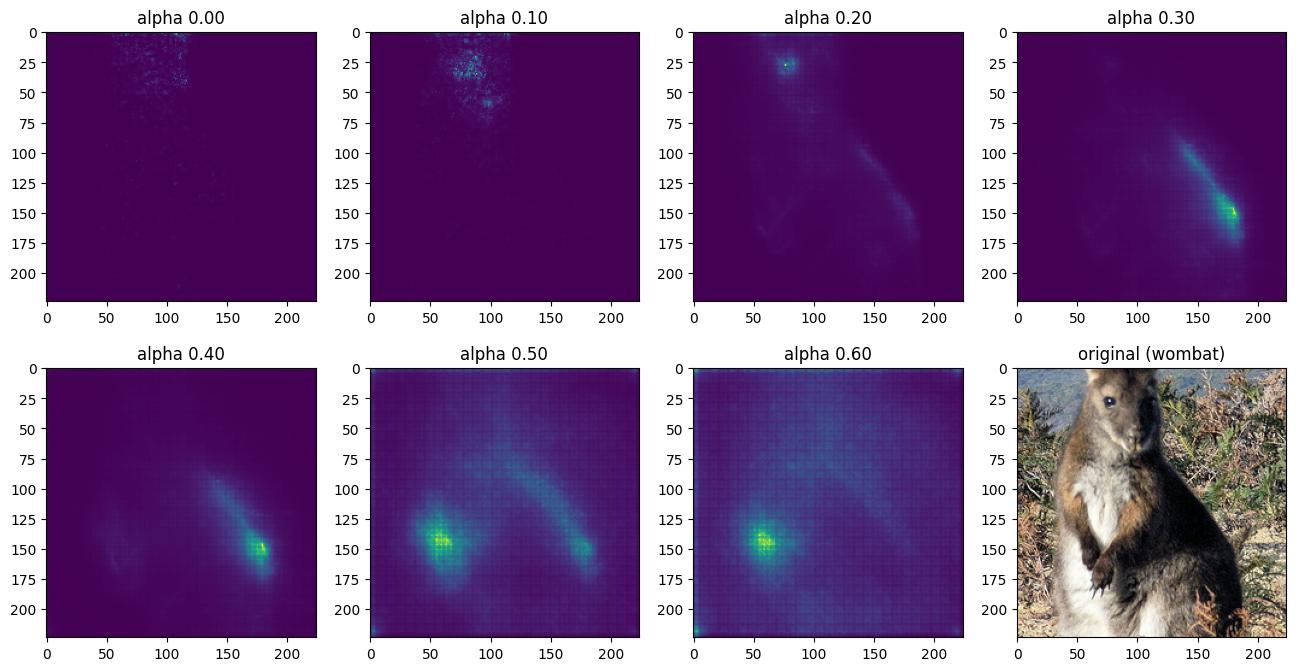

In [ ]:
image_index = 43
original_image, label, image_path = query_imagenet(image_index=image_index)
temp = project_metadata.loc[("vanilla_grad_mask", "meanx2", image_index, "gaussian")]
temp_masks = temp["data_path"].apply(np.load)
titles = temp.index.to_series().apply(lambda x: f"alpha {x:.2f}")
temp_masks = preprocess_masks(temp_masks, preprocesses=[sum_channels, minmax_normalize])
fig, axes = plot_masks(temp_masks, titles=titles, imshow_args=imshow_args, ncols=4)
axes[1, 3].imshow(original_image[0].squeeze(), **imshow_args)
axes[1, 3].set_title(f"original ({IMAGENET_LABELS[label]})")